## Brain MRI Segmentation with Unet | TensorFlow and Keras

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [21]:
# Setting size parameters of images
im_width = 256
im_height = 256

## Loading the image and mask paths

In [22]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine

# in Kaggle
filesLocation = r'C:\Users\winsweb\personal_project\python\ml\image_segmentations\archive\kaggle_3m\*\*_mask*'


mask_files = glob(filesLocation)

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)




['C:\\Users\\winsweb\\personal_project\\python\\ml\\image_segmentations\\archive\\kaggle_3m\\TCGA_CS_4941_19960909\\CHNCXR_0001_0.png', 'C:\\Users\\winsweb\\personal_project\\python\\ml\\image_segmentations\\archive\\kaggle_3m\\TCGA_CS_4941_19960909\\CHNCXR_0002_0.png', 'C:\\Users\\winsweb\\personal_project\\python\\ml\\image_segmentations\\archive\\kaggle_3m\\TCGA_CS_4941_19960909\\CHNCXR_0003_0.png', 'C:\\Users\\winsweb\\personal_project\\python\\ml\\image_segmentations\\archive\\kaggle_3m\\TCGA_CS_4941_19960909\\CHNCXR_0004_0.png', 'C:\\Users\\winsweb\\personal_project\\python\\ml\\image_segmentations\\archive\\kaggle_3m\\TCGA_CS_4941_19960909\\CHNCXR_0005_0.png', 'C:\\Users\\winsweb\\personal_project\\python\\ml\\image_segmentations\\archive\\kaggle_3m\\TCGA_CS_4941_19960909\\CHNCXR_0006_0.png', 'C:\\Users\\winsweb\\personal_project\\python\\ml\\image_segmentations\\archive\\kaggle_3m\\TCGA_CS_4941_19960909\\CHNCXR_0007_0.png', 'C:\\Users\\winsweb\\personal_project\\python\\ml\\ima

766

This function plots a grid of images and their corresponding masks from given lists of image and mask paths.
 It uses matplotlib for plotting and OpenCV for reading and processing the images.

In [23]:
plt.style.use("ggplot")

def plot_from_img_path(rows, columns, list_img_path, list_mask_path):  
 
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()


# Reading Some of the image for Lungs and Brain

In [5]:
# fax, ax = plt.subplots(fixsizes = (10, 10))
# ax.imshow(mask_files[1])
# plt.show


## Plotting few images and masks

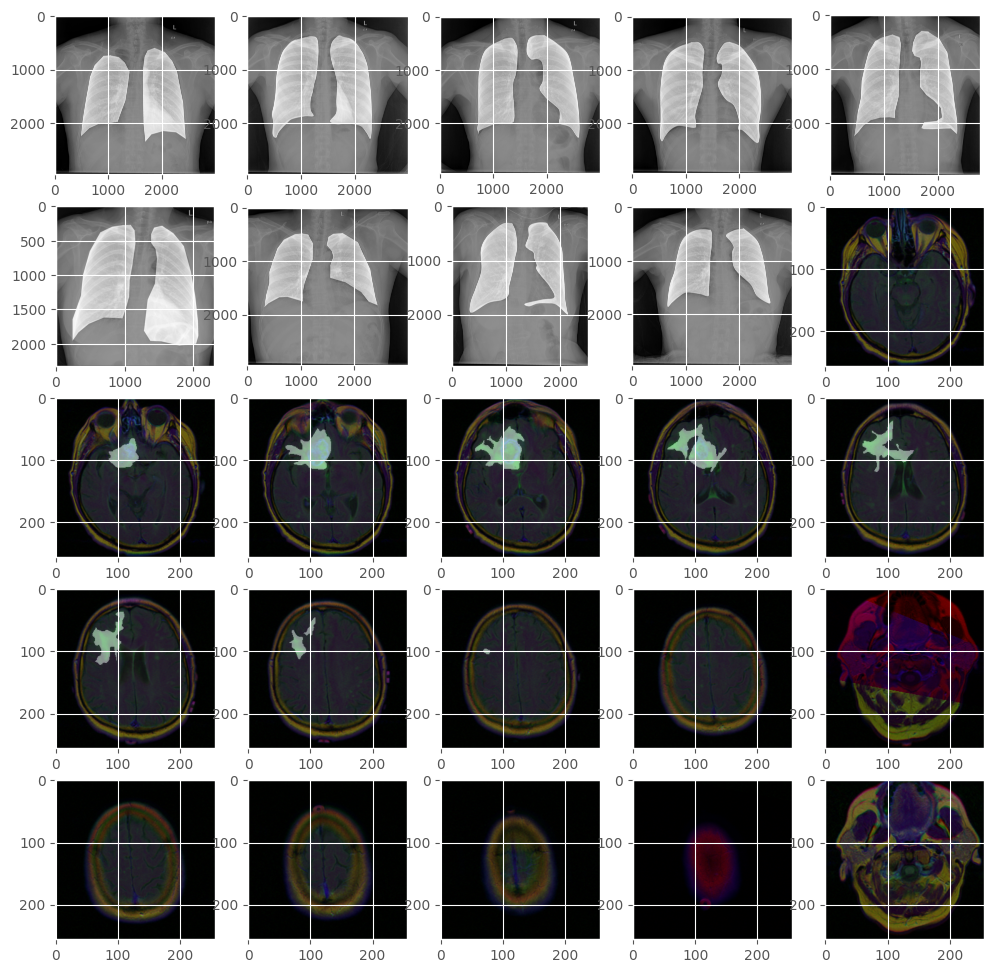

In [24]:
plot_from_img_path(5, 5 , image_filenames_train, mask_files )

# **Create data frame and split data on train set, validation set and test set**

In [25]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


(551, 2)
(77, 2)
(138, 2)


## **Data genertator, data augmentation and adjust data**

In [26]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [12]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [28]:
EPOCHS = 50
BATCH_SIZE = 4
# BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [29]:
model = unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 activation_36 (Activation)     (None, 256, 256, 64  0           ['conv2d_38[0][0]']              
                                )                                                           

In [30]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unetv.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 551 validated image filenames.
Found 551 validated image filenames.


c:\Users\winsweb\.conda\envs\tf210\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
138/137 [==============================] - ETA: 0s - loss: -0.2512 - binary_accuracy: 0.8481 - iou: 0.1618 - dice_coefficients: 0.2508Found 138 validated image filenames.
Found 138 validated image filenames.

Epoch 1: val_loss improved from inf to -0.08914, saving model to unetv.hdf5
137/137 [==============================] - 82s 559ms/step - loss: -0.2512 - binary_accuracy: 0.8481 - iou: 0.1618 - dice_coefficients: 0.2508 - val_loss: -0.0891 - val_binary_accuracy: 0.9472 - val_iou: 0.0487 - val_dice_coefficients: 0.0896
Epoch 2/50
138/137 [==============================] - ETA: 0s - loss: -0.3441 - binary_accuracy: 0.9382 - iou: 0.2362 - dice_coefficients: 0.3444
Epoch 2: val_loss did not improve from -0.08914
137/137 [==============================] - 57s 409ms/step - loss: -0.3441 - binary_accuracy: 0.9382 - iou: 0.2362 - dice_coefficients: 0.3444 - val_loss: -0.0608 - val_binary_accuracy: 0.9480 - val_iou: 0.0331 - val_dice_coefficients: 0.0609
Epoch 3/50
138/137 [======

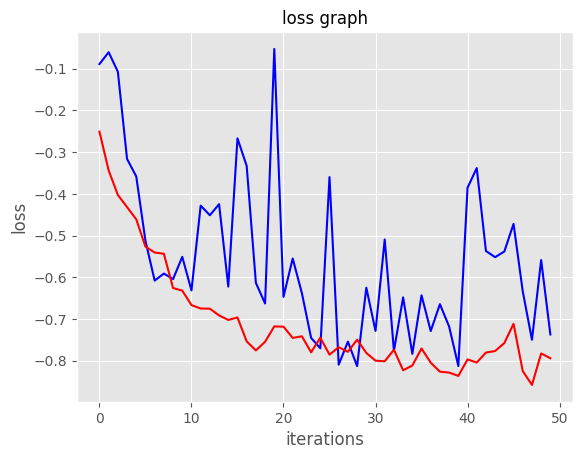

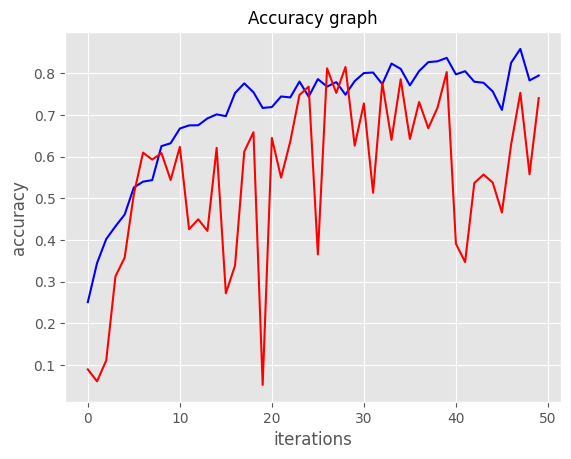

In [31]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

## Load previously trained Model

In [ ]:
# from tensorflow.keras.utils import CustomObjectScope

In [32]:
moodLo = r'C:\Users\winsweb\personal_project\python\ml\image_segmentations\unetv.hdf5'
model = load_model(moodLo, custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  } )
# model01 = load_model(moodLo )

In [33]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
# print('Test Dice Coefficient ', results[2] )


Found 77 validated image filenames.
Found 77 validated image filenames.
19/19 [==============================] - 8s 365ms/step - loss: -0.8417 - binary_accuracy: 0.9910 - iou: 0.7630 - dice_coefficients: 0.8405
Test Loss  -0.841678261756897
Test IoU  0.9910399317741394


## Plotting Predicted Masks Segmentation results from the Test Image set

1/1 [==============================] - 0s 25ms/step


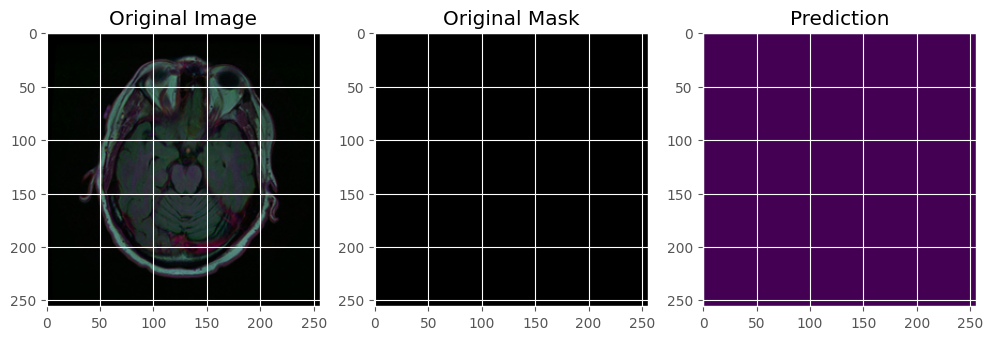

1/1 [==============================] - 0s 28ms/step


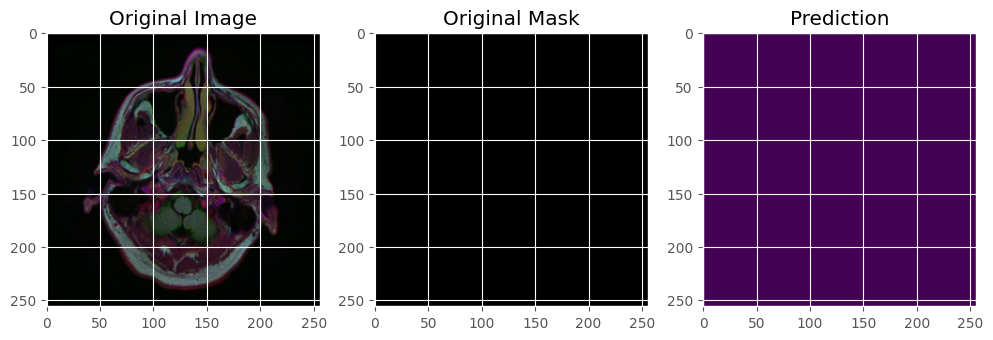

1/1 [==============================] - 0s 32ms/step


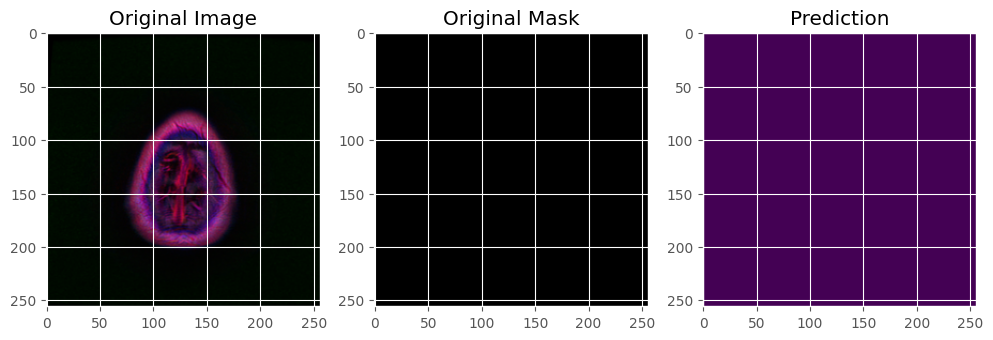

1/1 [==============================] - 0s 26ms/step


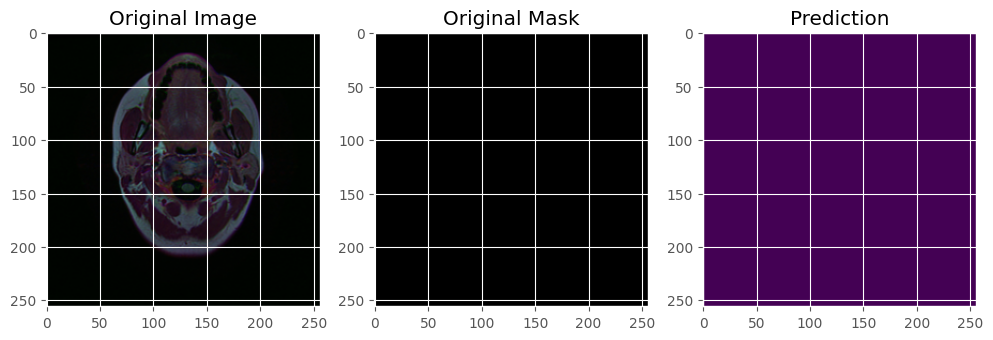

1/1 [==============================] - 0s 25ms/step


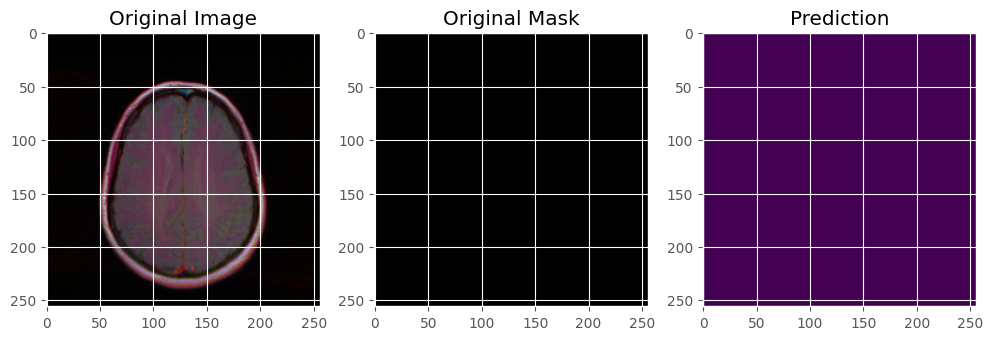

1/1 [==============================] - 0s 27ms/step


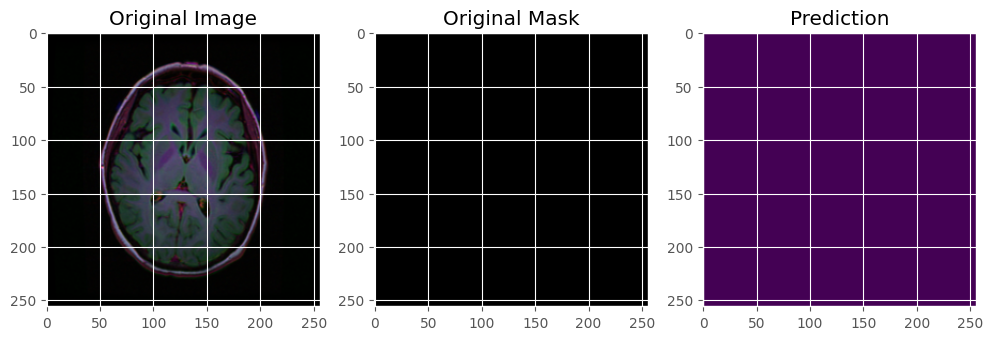

1/1 [==============================] - 0s 29ms/step


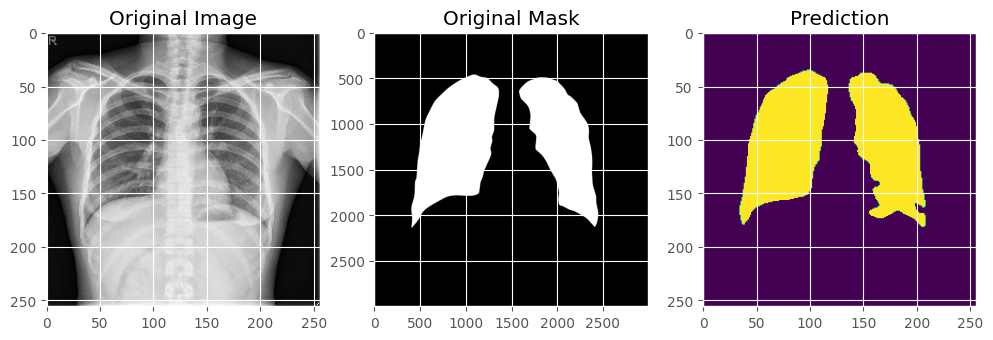

1/1 [==============================] - 0s 29ms/step


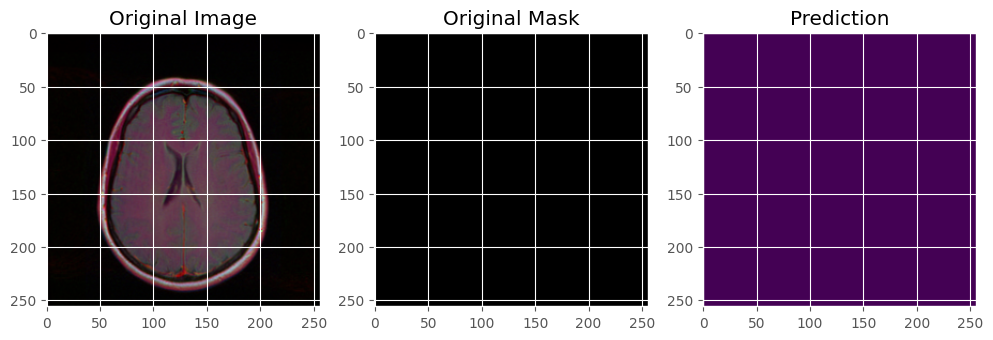

1/1 [==============================] - 0s 56ms/step


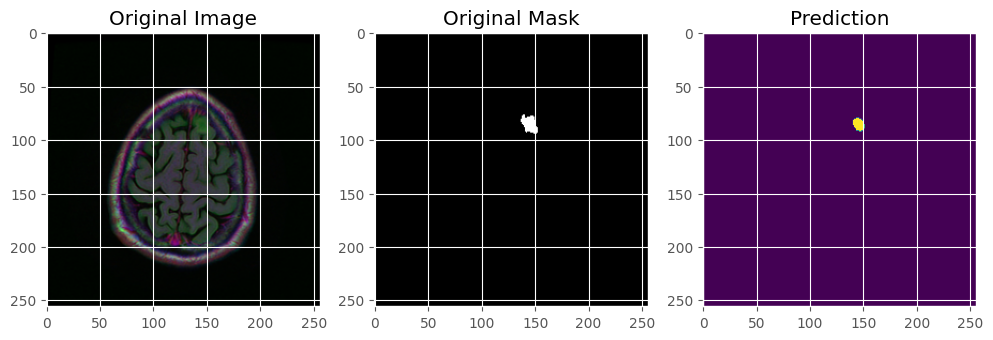

1/1 [==============================] - 0s 27ms/step


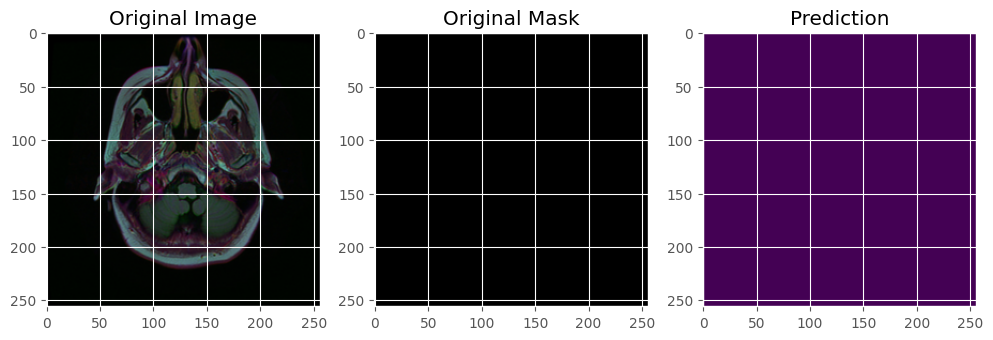

In [37]:
for i in range(10):
    index = np.random.randint(1, len(df_test.index))
    # index = np.random.ranint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

    